# INTRODUCTION

Traditional power plants can control how much power they produce which allows for power grid operators to easily manage supply and demand. However, most of these traditioanl power plants are coal powered, which are a massive source of air pollution. Integrating renewable energy power plants into the grid would greatly help reduce pollution, however renewable energy sources like solar and wind have variable output since they depend on other factors, primarily the weather. For example, a solar farm will produce more electricity on sunny days than on cloudy days, and this makes it difficult for grid operators to manage supply and demand. Forecasting power output for variable renewable energy sources can help here in that the operators can then know how much power to expect in the future, and if it isn't enough to meet the demand, they can have a traditional power plant on standby, and power it up when the the supply dips below what is needed. The idea here is that by forecasting power output of a solar plant, we can balance it with other sources of power generation. 

My goal in this project is to accomplish this by using machine learning algorithms for time series forecasting. I'm going to use 3 different alogorithms: SARIMA, Facebook PROPHET, and SARIMAX. And then compare them to see which performs the best.

let's start by importing the necessary libraries.

---

# Importing Libraries

In [308]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np

# metrics
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# models
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

# api
import json
import requests

---

# Importing Data & Data Understanding

#### **POWER OUTPUT DATA:**

In [33]:
# power output data for plant 1
p1_gen = pd.read_csv('../../data/Plant_1_Generation_Data.csv')

In [34]:
# looking at the first 5 records:

p1_gen.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


**Columns:**

DATE_TIME: Date and timestamp of datapoint- taken every 15 minute

PLANT_ID: ID of Plant 1

SOURCE_KEY: Inverter ID

DC_POWER: DC power produced by inverter in that 15 minute interval (in kW)

AC_POWER: AC power produced by inverter in that 15 minute interval (in kW)

DAILY_YIELD: Total power produced till that point in time

TOTAL_YIELD: Total yield for the inverter till that point in time

Looking at the info below, we can see there are no missing nor duplicated values.

In [35]:
p1_gen.info()
print('\n')
print ("Number of duplicate values: ", p1_gen.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


Number of duplicate values:  0


#### **INVERTERS:**

There are 22 inverters, each with a unique ID. So each specific timestamp has 22 records for each inverter.

In [36]:
print("Number of unique Inverter IDs: ", len(p1_gen.SOURCE_KEY.unique()))
p1_gen.SOURCE_KEY.unique()

Number of unique Inverter IDs:  22


array(['1BY6WEcLGh8j5v7', '1IF53ai7Xc0U56Y', '3PZuoBAID5Wc2HD',
       '7JYdWkrLSPkdwr4', 'McdE0feGgRqW7Ca', 'VHMLBKoKgIrUVDU',
       'WRmjgnKYAwPKWDb', 'ZnxXDlPa8U1GXgE', 'ZoEaEvLYb1n2sOq',
       'adLQvlD726eNBSB', 'bvBOhCH3iADSZry', 'iCRJl6heRkivqQ3',
       'ih0vzX44oOqAx2f', 'pkci93gMrogZuBj', 'rGa61gmuvPhdLxV',
       'sjndEbLyjtCKgGv', 'uHbuxQJl8lW7ozc', 'wCURE6d3bPkepu2',
       'z9Y9gH1T5YWrNuG', 'zBIq5rxdHJRwDNY', 'zVJPv84UY57bAof',
       'YxYtjZvoooNbGkE'], dtype=object)

#### **WEATHER DATA:**

In [37]:
# weather data for plant 1
p1_wthr = pd.read_csv('../../data/Plant_1_Weather_Sensor_Data.csv')

In [38]:
# looking at the first 5 records:

p1_wthr.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


**Columns:**

DATE_TIME: Date and timestamp of the datapoint- taken every 15 minutes. Same as above

SOURCE_KEY: Module ID of the weather sensor

AMBIENT_TEMPERATURE: Weather temperature

MODULE_TEMPERATURE: Solar panel temperature

IRRADIATION: Amount of irradiation for the 15 minute interval.


Confirming the SOURCE_KEY here is different from the inverter IDs above:

In [39]:
# confiming weather sensor SOURCE_KEY is different from the ones in the gen df

p1_wthr.SOURCE_KEY.unique() in p1_gen.SOURCE_KEY.unique()

False

Looking at the info below, we can see there are no missing nor duplicated values.

In [40]:
p1_wthr.info()
print ("Number of duplicate values: ", p1_wthr.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB
Number of duplicate values:  0


#### **CHECKING FOR STATIONARITY**

A time series data is said to be stationary if its statistical properties, such as mean, variance, etc, remain constant over time. When doing time series modeling, it is important that our data is stationary. This is because if our dataset shows a particular behavior over time, there is a very high probability that it will follow a similar behavior in the future.

The plot below shows that our power output dataset has daily seasonality, therefore it is NOT stationary. Which makes sense since the power output peaks during the day when the sun is out, and drops during the night.

I'm going to take care of this by tuning the respective model parameters in the modeling section. 

<ipython-input-328-9d06fbaab3d8>:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(df), label='Original', color='blue')


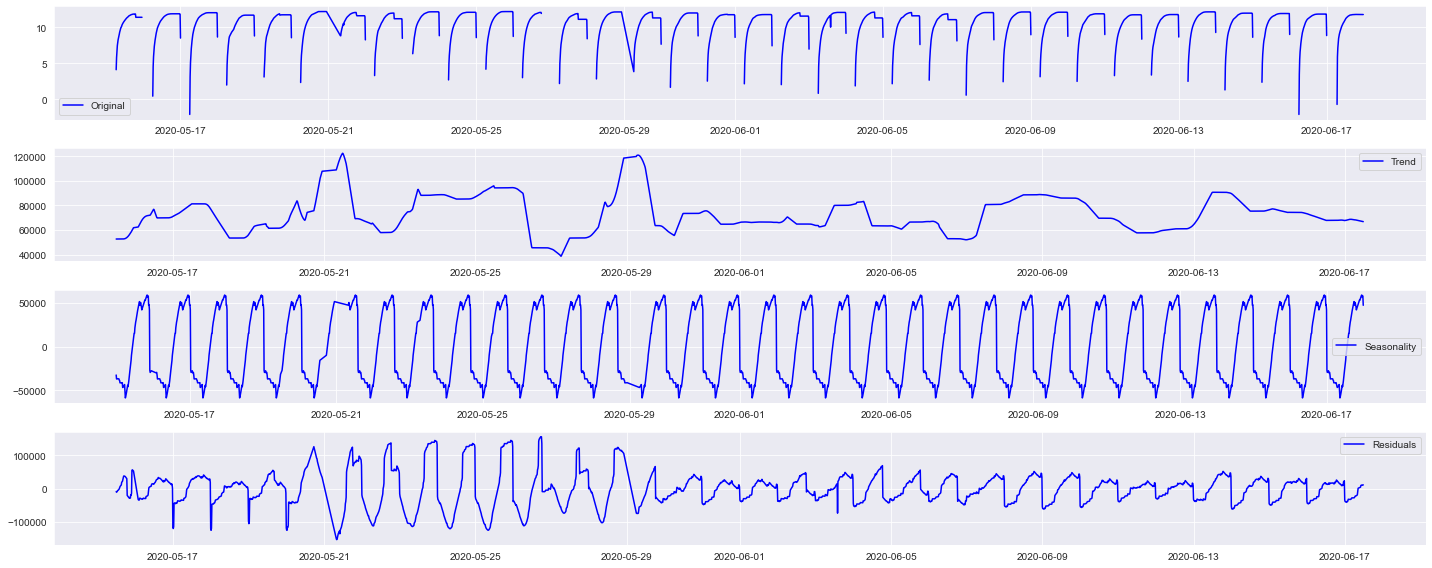

In [328]:
# Below I'm going to group all the inverters together by date_time, and sum the daily_yield
df = p1_gen.groupby(p1_gen.index).sum()[['DAILY_YIELD']]

# period equals 96 because that is the number of 15 minute periods we have in a day.
decomposition = seasonal_decompose(df, period=96)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20,8))
plt.title('Seasonal Decomposition \n Plant 1 Daily Yield', size=19)
plt.subplot(411)
plt.plot(np.log(df), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('seasonal_decomp.png');

---

# Data Preparation For Modeling

We need to first set the date_time column as the index for both dataframes:

In [41]:
# power output data for plant 1:

# converting date_time column to date_time object
p1_gen.DATE_TIME = pd.to_datetime(p1_gen.DATE_TIME, infer_datetime_format=True)
p1_wthr.DATE_TIME = pd.to_datetime(p1_wthr.DATE_TIME, infer_datetime_format=True)

# setting the date_time column as the index
p1_gen.set_index('DATE_TIME', inplace=True)
p1_wthr.set_index('DATE_TIME', inplace=True)

In [42]:
p1_gen.head()

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [43]:
p1_wthr.head()

,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,
2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


Isolating the last 5 days of power output data (6/13 to 6/17), and grouping daily_yield by date_time:

In [46]:
pred_gen = p1_gen[(p1_gen.index.month == 6) & 
                 (p1_gen.index.day >= 13) &
                 (p1_gen.index.day <= 17)].groupby('DATE_TIME').sum()[['DAILY_YIELD']]
pred_gen

,DAILY_YIELD
DATE_TIME,
2020-06-13 00:00:00,5683.214286
2020-06-13 00:15:00,0.000000
2020-06-13 00:30:00,0.000000
2020-06-13 00:45:00,0.000000
2020-06-13 01:00:00,0.000000
...,...
2020-06-17 22:45:00,129571.000000
2020-06-17 23:00:00,129571.000000
2020-06-17 23:15:00,129571.000000


Isolating the last 5 days of weather sensor data:

In [48]:
pred_wthr = p1_wthr[(p1_wthr.index.month == 6) & 
                    (p1_wthr.index.day >= 13) & 
                    (p1_wthr.index.day <= 17)]
pred_wthr

,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,
2020-06-13 00:00:00,4135001,HmiyD2TTLFNqkNe,21.771613,19.357530,0.0
2020-06-13 00:15:00,4135001,HmiyD2TTLFNqkNe,21.730046,19.504081,0.0
2020-06-13 00:30:00,4135001,HmiyD2TTLFNqkNe,21.687068,19.562803,0.0
2020-06-13 00:45:00,4135001,HmiyD2TTLFNqkNe,21.619232,19.559182,0.0
2020-06-13 01:00:00,4135001,HmiyD2TTLFNqkNe,21.625968,19.787058,0.0
...,...,...,...,...,...
2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0
2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0
2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0


Here we can see that our weather sensor data has 2 extra rows (480 vs 478), meaning our power output data is missing those 2 rows.

#### **FILLING IN MISSING ROWS**

Creating a merged df with an indicator column (_merge) letting us know which df the row came from:

In [50]:
df_with_indicator = pd.merge(pred_wthr, pred_gen, 
                           left_index=True, right_index=True, 
                           how='outer', suffixes=('','_y'), indicator=True)
df_with_indicator

,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAILY_YIELD,_merge
DATE_TIME,,,,,,,
2020-06-13 00:00:00,4135001,HmiyD2TTLFNqkNe,21.771613,19.357530,0.0,5683.214286,both
2020-06-13 00:15:00,4135001,HmiyD2TTLFNqkNe,21.730046,19.504081,0.0,0.000000,both
2020-06-13 00:30:00,4135001,HmiyD2TTLFNqkNe,21.687068,19.562803,0.0,0.000000,both
2020-06-13 00:45:00,4135001,HmiyD2TTLFNqkNe,21.619232,19.559182,0.0,0.000000,both
2020-06-13 01:00:00,4135001,HmiyD2TTLFNqkNe,21.625968,19.787058,0.0,0.000000,both
...,...,...,...,...,...,...,...
2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0,129571.000000,both
2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0,129571.000000,both
2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0,129571.000000,both


Isolating rows where the merge column = 'left only', indicating it came from p1_wthr: 

In [53]:
rows_in_df1_not_in_df2 = df_with_indicator[df_with_indicator['_merge']=='left_only'][pred_wthr.columns]

rows_in_df1_not_in_df2

,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,
2020-06-17 06:15:00,4135001,HmiyD2TTLFNqkNe,22.093398,20.822978,0.019175
2020-06-17 06:30:00,4135001,HmiyD2TTLFNqkNe,22.275627,21.973568,0.034624


Below we see that that we're missing records for 6:15am & 6:30am on 6/17/2020.

It also looks like, due to the time of day, no power was generated.

So we're going to add these date_time records with a daily yield of 0 to the power output data.

In [28]:
# Confirming the above data is missing from power output data: 

pred_6_13[(pred_6_13.index >= '2020-06-17 06:00:00') & (pred_6_13.index <= '2020-06-17 07:00:00')]

# looks like it's just missing. the daily yield here was most likely 0 for both time stamps

,DAILY_YIELD
DATE_TIME,
2020-06-17 06:00:00,0.000000
2020-06-17 06:45:00,0.500000
2020-06-17 07:00:00,362.660714


In [56]:
# adding rows with index '2020-06-17 06:15:00' & '2020-06-17 06:30:00', with col val of 0, to end of df
pred_gen.loc[pd.to_datetime('2020-06-17 06:15:00')] = 0
pred_gen.loc[pd.to_datetime('2020-06-17 06:30:00')] = 0

# sorting df by index and setting in place
pred_gen.sort_index(inplace=True)

# confirming row was inserted correctly
pred_gen[(pred_gen.index >= '2020-06-17 06:00:00') & (pred_gen.index <= '2020-06-17 07:00:00')]

,DAILY_YIELD
DATE_TIME,
2020-06-17 06:00:00,0.000000
2020-06-17 06:15:00,0.000000
2020-06-17 06:30:00,0.000000
2020-06-17 06:45:00,0.500000
2020-06-17 07:00:00,362.660714


In [57]:
print('pred_gen records: ', len(pred_gen))
print('pred_wthr records: ', len(pred_wthr))

pred_gen records:  480
pred_wthr records:  480


#### **FINAL COMBINED DATAFRAME FOR OUR MODEL**

We're only going to use ambient temperature from our weather sensor data in this project, so that is the only column we're going to add to our final dataframe here.

In [60]:
pred_final = pred_gen.merge(pred_wthr[['AMBIENT_TEMPERATURE']], 
                left_index=True, right_index=True)
pred_final

,DAILY_YIELD,AMBIENT_TEMPERATURE
DATE_TIME,,
2020-06-13 00:00:00,5683.214286,21.771613
2020-06-13 00:15:00,0.000000,21.730046
2020-06-13 00:30:00,0.000000,21.687068
2020-06-13 00:45:00,0.000000,21.619232
2020-06-13 01:00:00,0.000000,21.625968
...,...,...
2020-06-17 22:45:00,129571.000000,22.150570
2020-06-17 23:00:00,129571.000000,22.129816
2020-06-17 23:15:00,129571.000000,22.008275


#### **TRAIN/TEST SPLIT**

In [61]:
eotri = round(pred_final.shape[0] * .8)

train_pred_fin = pred_final[:eotri]

test_pred_fin = pred_final[eotri:]

print(train_pred_fin.shape, test_pred_fin.shape)

(384, 2) (96, 2)


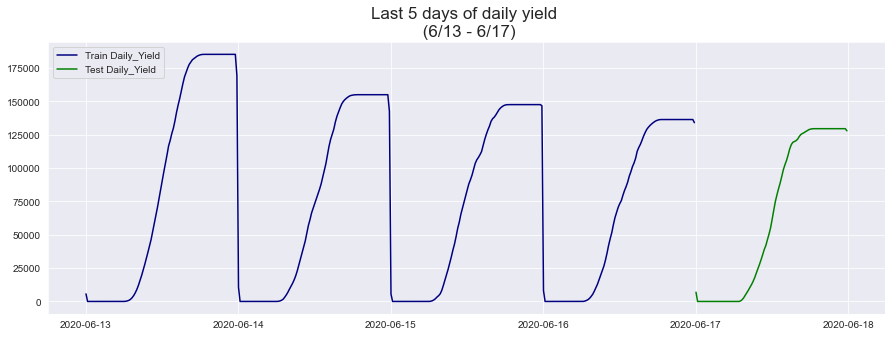

In [331]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(train_pred_fin.DAILY_YIELD, label='Train Daily_Yield', color='navy')
ax.plot(test_pred_fin.DAILY_YIELD, label='Test Daily_Yield', color='green')
ax.set_title('Last 5 days of daily yield \n (6/13 - 6/17)', fontsize=17)
ax.legend(loc='upper left');
plt.savefig('train_test_data.png')

---

# Modeling 1: SARIMA

SARIMA stands for Seasonal AutoRegressive Integrated Moving Average, and is a very popular time series forecasting model. 

For our first model, we're only going to use the DAILY_YIELD to forecast forward, let's go ahead and isolate that feature:

In [62]:
train_sarima = train_pred_fin[['DAILY_YIELD']]
test_sarima = test_pred_fin[['DAILY_YIELD']]

In [65]:
train_sarima.head()

,DAILY_YIELD
DATE_TIME,
2020-06-13 00:00:00,5683.214286
2020-06-13 00:15:00,0.000000
2020-06-13 00:30:00,0.000000
2020-06-13 00:45:00,0.000000
2020-06-13 01:00:00,0.000000


In [66]:
test_sarima.head()

,DAILY_YIELD
DATE_TIME,
2020-06-17 00:00:00,6955.232143
2020-06-17 00:15:00,0.000000
2020-06-17 00:30:00,0.000000
2020-06-17 00:45:00,0.000000
2020-06-17 01:00:00,0.000000


#### **STATIONARITY**

As mentioned in the data understanding section above, the power output dataset exhibits daily seasonality, meaning that the dataset is NOT stationary. We can further confirm this by doing a **Dicky-Fuller Test**, which is a statistical test for checking stationarity.

The test assumes a null-hypothesis that the time series is not stationary. So if the test statistics is less than the critical value, we then reject that null hypothesis and say that the series is stationary.

This is not the case with our dataset, as we can see below. The test statistic is greater than the critical value at 5%, confirming that our dataset is not stationary. 

I'm going take care of this by tuning parameters within each of the models.

In [316]:
dftest = adfuller(pred_final['DAILY_YIELD'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

print('-'*15)

if dftest[0] <= dftest[4]['5%']:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis, indicating the data is NON-stationary ")

Results of Dickey-Fuller test: 

Test Statistic                  -2.600505
p-value                          0.092893
#Lags Used                       1.000000
Number of Observations Used    478.000000
Critical Value (1%)             -3.444105
Critical Value (5%)             -2.867606
Critical Value (10%)            -2.570001
dtype: float64
---------------
weak evidence against null hypothesis, indicating the data is NON-stationary 


#### **AUTO-ARIMA**

--> **ENTER EXPLANATION AIC (since that is what we're minimizing here)** <--

In [94]:
auto_arima(train_sarima,
           start_p=0,d=1,start_q=0,
           max_p=4,max_d=4,max_q=4,
           start_P=0,D=1,start_Q=0,
           max_P=1,max_D=1,max_Q=1,m=96,
           seasonal=True,
           error_action='warn',trace=True,
           supress_warning=True,stepwise=True,
           random_state=20,n_fits=1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[96]             : AIC=5102.205, Time=2.27 sec
 ARIMA(1,1,0)(1,1,0)[96]             : AIC=4821.779, Time=36.44 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,1)(0,1,1)[96]             : AIC=4895.577, Time=10.77 sec
 ARIMA(1,1,0)(0,1,0)[96]             : AIC=5088.074, Time=2.05 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,0)(1,1,1)[96]             : AIC=4811.024, Time=76.08 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,0)(0,1,1)[96]             : AIC=4894.495, Time=14.32 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,0)(1,1,1)[96]             : AIC=4934.987, Time=25.79 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(2,1,0)(1,1,1)[96]             : AIC=4897.523, Time=34.52 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,1)(1,1,1)[96]             : AIC=4898.438, Time=34.51 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,1)(1,1,1)[96]             : AIC=4897.373, Time=27.78 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(2,1,1)(1,1,1)[96]             : AIC=4899.901, Time=45.03 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,0)(1,1,1)[96] intercept   : AIC=4812.288, Time=67.98 sec

Best model:  ARIMA(1,1,0)(1,1,1)[96]          
Total fit time: 377.823 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 1, 1, 96),
      with_intercept=False)

#### **TRAIN/TEST MODEL, AND IN-SAMPLE PREDICTION**

FITTING MODEL TO TRAIN DATA

In [212]:
p,d,q = [1,1,0]
P,D,Q,s = [1,1,1,96]

sarima_model = SARIMAX(endog=train_sarima, 
                      order=(p,d,q),
                      seasonal_order=(P,D,Q,s),
                      freq='15T').fit()

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAKING PREDICTIONS AGAINST TRAIN AND TEST DATA (y_hats)

In [213]:
train_sarima_y_hat = pd.DataFrame(sarima_model.predict(typ='levels'), columns=['pred_daily_yld'])

test_sarima_y_hat = pd.DataFrame(sarima_model.predict(start=test_sarima.index[0],
                                                      end=test_sarima.index[-1],
                                                      typ='levels'), columns=['pred_daily_yld'])

# zero out negative predictions:
train_sarima_y_hat[train_sarima_y_hat < 0] = 0

test_sarima_y_hat[test_sarima_y_hat < 0] = 0

In [214]:
train_sarima_y_hat.head()

,pred_daily_yld
2020-06-13 00:00:00,0.000000
2020-06-13 00:15:00,5811.320199
2020-06-13 00:30:00,0.000000
2020-06-13 00:45:00,0.000000
2020-06-13 01:00:00,0.000000


In [215]:
test_sarima_y_hat.head()

,pred_daily_yld
2020-06-17 00:00:00,0.0
2020-06-17 00:15:00,0.0
2020-06-17 00:30:00,0.0
2020-06-17 00:45:00,0.0
2020-06-17 01:00:00,0.0


PERFORMANCE METRICS; PLOTTING

SARIMA train R2 Score: 0.984636
SARIMA test R2 Score: 0.992781
---------------
SARIMA train MAE Score: 1271.469147
SARIMA test MAE Score: 3392.311740
---------------
SARIMA train RMSE Score: 8481.602910
SARIMA test RMSE Score: 4836.309328
--------------- 

                                      SARIMAX Results                                       
Dep. Variable:                          DAILY_YIELD   No. Observations:                  384
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 96)   Log Likelihood               -2401.512
Date:                              Wed, 02 Dec 2020   AIC                           4811.024
Time:                                      19:16:53   BIC                           4825.662
Sample:                                  06-13-2020   HQIC                          4816.891
                                       - 06-16-2020                                         
Covariance Type:                                opg                                         

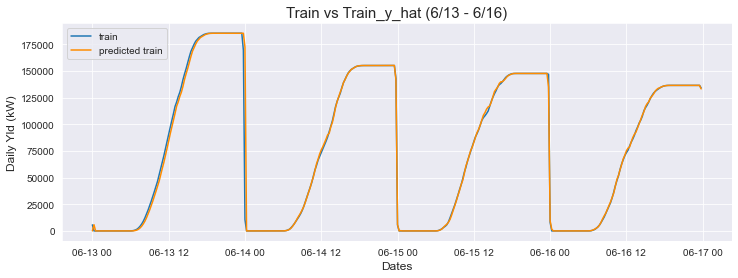

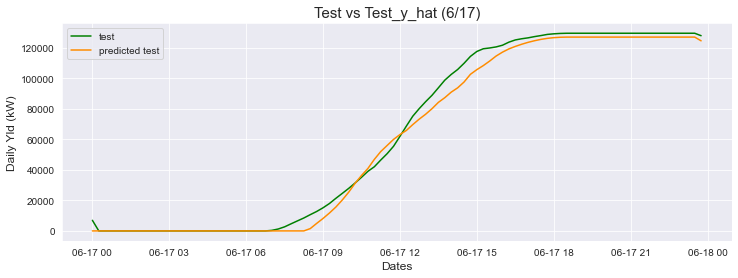

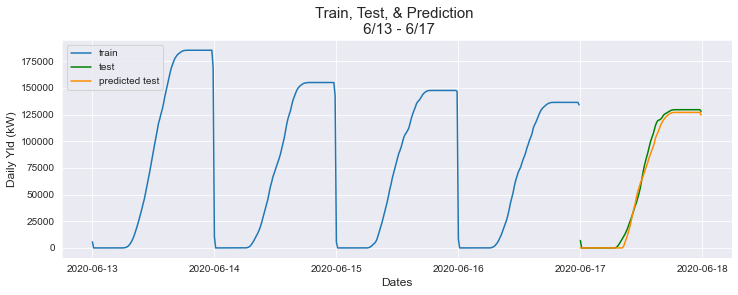

In [329]:
print('SARIMA train R2 Score: %f' % (r2_score(train_sarima.DAILY_YIELD,
                                              train_sarima_y_hat.pred_daily_yld)))
print('SARIMA test R2 Score: %f' % (r2_score(test_sarima.DAILY_YIELD,
                                              test_sarima_y_hat.pred_daily_yld)))

print('-'*15)


print('SARIMA train MAE Score: %f' % (mean_absolute_error(train_sarima.DAILY_YIELD,
                                                          train_sarima_y_hat.pred_daily_yld)))
print('SARIMA test MAE Score: %f' % (mean_absolute_error(test_sarima.DAILY_YIELD,
                                                          test_sarima_y_hat.pred_daily_yld)))

print('-'*15)


print('SARIMA train RMSE Score: %f' % (mean_squared_error(train_sarima.DAILY_YIELD,
                                                          train_sarima_y_hat.pred_daily_yld,
                                                          squared=False)))
print('SARIMA test RMSE Score: %f' % (mean_squared_error(test_sarima.DAILY_YIELD,
                                                          test_sarima_y_hat.pred_daily_yld,
                                                          squared=False)))

print('-'*15, '\n')


print(sarima_model.summary())


print('-'*15)


fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(train_sarima, label='train')
ax1.plot(train_sarima_y_hat, label='predicted train', c='darkorange')
ax1.legend(loc='upper left')
ax1.set_title('Train vs Train_y_hat (6/13 - 6/16)', size=15)
ax1.set_ylabel('Daily Yld (kW)', size=12)
ax1.set_xlabel('Dates', size=12) 

fig, ax2 = plt.subplots(figsize=(12,4))
ax2.plot(test_sarima, label='test', c='g')
ax2.plot(test_sarima_y_hat, label='predicted test', c='darkorange')
ax2.legend(loc='upper left')
ax2.set_title('Test vs Test_y_hat (6/17)', size=15)
ax2.set_ylabel('Daily Yld (kW)', size=12)
ax2.set_xlabel('Dates', size=12) 

fig, ax3 = plt.subplots(figsize=(12,4))
ax3.plot(train_sarima, label='train')
ax3.plot(test_sarima, label='test', c='g')
ax3.plot(test_sarima_y_hat, label='predicted test', c='darkorange')
ax3.legend(loc='upper left')
ax3.set_title('Train, Test, & Prediction \n 6/13 - 6/17', size=15)
ax3.set_ylabel('Daily Yld (kW)', size=12)
ax3.set_xlabel('Dates', size=12);
# plt.savefig('sarime_pred.png')

#### **FORECASTING**

Fit the model to the entire train/test data:

In [145]:
sarima_f_model = SARIMAX(pred_final.DAILY_YIELD,
                         order=(p,d,q),
                         seasonal_order=(P,D,Q,s),
                         freq='15T').fit()

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [154]:
sarima_forecast = sarima_f_model.get_forecast(steps=193).summary_frame()
sarima_forecast

DAILY_YIELD,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-06-18 00:00:00,-240.062415,1136.566162,-2467.691159,1987.566328
2020-06-18 00:15:00,-7278.650324,1658.447592,-10529.147874,-4028.152774
2020-06-18 00:30:00,-7277.625865,2054.242470,-11303.867122,-3251.384608
2020-06-18 00:45:00,-7277.586392,2385.383343,-11952.851834,-2602.320950
2020-06-18 01:00:00,-7277.584594,2675.862055,-12522.177849,-2032.991339
...,...,...,...,...
2020-06-19 23:00:00,119370.674623,24256.803815,71828.212765,166913.136482
2020-06-19 23:15:00,119370.758341,24355.837577,71634.193876,167107.322806
2020-06-19 23:30:00,119373.248201,24454.470272,71443.367207,167303.129195
2020-06-19 23:45:00,117288.213091,24552.706455,69165.792716,165410.633466


In [155]:
sarima_forecast[sarima_forecast < 0] = 0
sarima_forecast

DAILY_YIELD,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-06-18 00:00:00,0.000000,1136.566162,0.000000,1987.566328
2020-06-18 00:15:00,0.000000,1658.447592,0.000000,0.000000
2020-06-18 00:30:00,0.000000,2054.242470,0.000000,0.000000
2020-06-18 00:45:00,0.000000,2385.383343,0.000000,0.000000
2020-06-18 01:00:00,0.000000,2675.862055,0.000000,0.000000
...,...,...,...,...
2020-06-19 23:00:00,119370.674623,24256.803815,71828.212765,166913.136482
2020-06-19 23:15:00,119370.758341,24355.837577,71634.193876,167107.322806
2020-06-19 23:30:00,119373.248201,24454.470272,71443.367207,167303.129195
2020-06-19 23:45:00,117288.213091,24552.706455,69165.792716,165410.633466


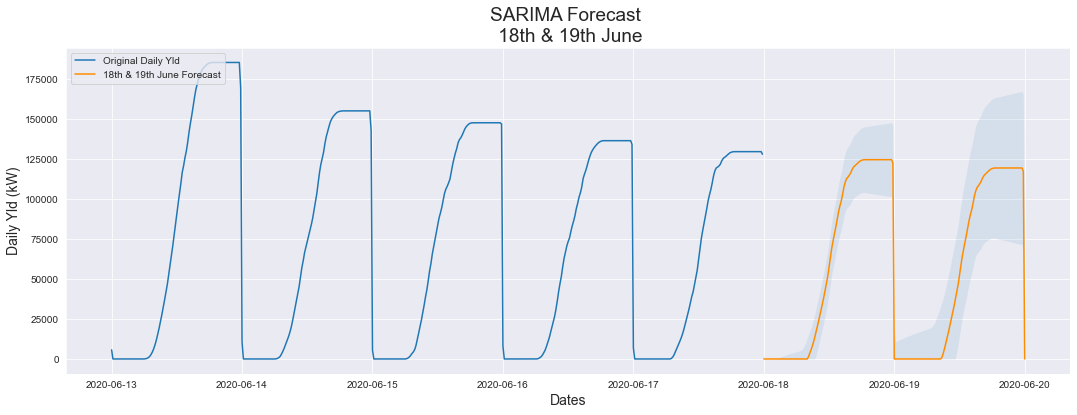

In [332]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pred_final.DAILY_YIELD, label='Original Daily Yld')
ax.plot(sarima_forecast['mean'], label='18th & 19th June Forecast', c='darkorange')
ax.fill_between(sarima_forecast.index, 
                sarima_forecast.mean_ci_lower, sarima_forecast.mean_ci_upper, alpha=0.1)

ax.legend(loc='upper left')
ax.set_title('SARIMA Forecast \n 18th & 19th June', size=19)
ax.set_ylabel('Daily Yld (kW)', size=14)
ax.set_xlabel('Dates', size=14);
# plt.savefig('../../data/figures/sarima_forecast.png')

In [170]:
print('18th Jun Forecasted Output: ', 
     round(sarima_forecast[sarima_forecast.index.day == 18]['mean'].max(), 0),
     'kW')

print('19th Jun Forecasted Output: ', 
     round(sarima_forecast[sarima_forecast.index.day == 19]['mean'].max(), 0),
     'kW')

18th Jun Forecasted Output:  124556.0 kW
19th Jun Forecasted Output:  119373.0 kW


---

# Modeling 2: FB Prophet

PROPHET is an open source library by Facebook which can be used for time series forecasting. It is more intuitive than SARIMAX, and also faster.

In [264]:
prophet_train = train_pred_fin.copy()[['DAILY_YIELD']]
prophet_test = test_pred_fin.copy()[['DAILY_YIELD']]

In [265]:
# need to have two columns for prophet modeling 
# And change their names to ds (datetime) and y (prior datetime data) for prophet
# below transforms the index into a column

prophet_train.reset_index(inplace=True)
prophet_train.columns = ['ds', 'y']

prophet_test.reset_index(inplace=True)
prophet_test.columns = ['ds', 'y']

In [266]:
prophet_train.head()

,ds,y
0,2020-06-13 00:00:00,5683.214286
1,2020-06-13 00:15:00,0.000000
2,2020-06-13 00:30:00,0.000000
3,2020-06-13 00:45:00,0.000000
4,2020-06-13 01:00:00,0.000000


In [267]:
prophet_test.head()

,ds,y
0,2020-06-17 00:00:00,6955.232143
1,2020-06-17 00:15:00,0.000000
2,2020-06-17 00:30:00,0.000000
3,2020-06-17 00:45:00,0.000000
4,2020-06-17 01:00:00,0.000000


#### **TRAIN/TEST MODEL, AND IN-SAMPLE PREDICTION**

Instantiating model & Fitting model to training data

In [268]:
prophet_model = Prophet(daily_seasonality=True, 
                     weekly_seasonality=False, 
                     yearly_seasonality=False, 
                     interval_width=0.95) # confidence interval. Note: entering this did not change any of the performance metric vs the the defaul 

prophet_model.fit(prophet_train)

I'm going to now make a list of future dates to predict values for. Note that these are the same dates as the prophet_test data index.

In [270]:
prophet_future_test_dates = prophet_model.make_future_dataframe(periods=96, freq='15min', include_history=False)
prophet_future_test_dates

,ds
0,2020-06-17 00:00:00
1,2020-06-17 00:15:00
2,2020-06-17 00:30:00
3,2020-06-17 00:45:00
4,2020-06-17 01:00:00
...,...
91,2020-06-17 22:45:00
92,2020-06-17 23:00:00
93,2020-06-17 23:15:00
94,2020-06-17 23:30:00


Predicting: I'm going to predict values for the dates we created above. We will then comapre these values to the actual daily yield from our test data.

In [271]:
prophet_test_forecast = prophet_model.predict(prophet_future_test_dates)
prophet_test_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-17 00:00:00,63767.068850,24579.175905,92802.246485,63766.009897,63767.390083,-5609.585587,-5609.585587,-5609.585587,-5609.585587,-5609.585587,-5609.585587,0.0,0.0,0.0,58157.483263
1,2020-06-17 00:15:00,63689.596914,7929.643029,78372.468096,63680.170035,63697.115274,-20411.610065,-20411.610065,-20411.610065,-20411.610065,-20411.610065,-20411.610065,0.0,0.0,0.0,43277.986849
2,2020-06-17 00:30:00,63612.124977,-6776.025591,66774.556056,63591.170787,63630.342463,-34598.757656,-34598.757656,-34598.757656,-34598.757656,-34598.757656,-34598.757656,0.0,0.0,0.0,29013.367322
3,2020-06-17 00:45:00,63534.653041,-18409.708949,53153.843256,63496.407359,63568.874337,-47773.025513,-47773.025513,-47773.025513,-47773.025513,-47773.025513,-47773.025513,0.0,0.0,0.0,15761.627529
4,2020-06-17 01:00:00,63457.181105,-34414.547999,38833.271145,63401.960367,63507.983835,-59587.592238,-59587.592238,-59587.592238,-59587.592238,-59587.592238,-59587.592238,0.0,0.0,0.0,3869.588867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2020-06-17 22:45:00,56717.122658,89368.574692,157741.771484,52138.066538,61231.455158,62772.438958,62772.438958,62772.438958,62772.438958,62772.438958,62772.438958,0.0,0.0,0.0,119489.561615
92,2020-06-17 23:00:00,56639.650721,72068.985764,145032.131521,51999.001519,61251.930762,51172.584580,51172.584580,51172.584580,51172.584580,51172.584580,51172.584580,0.0,0.0,0.0,107812.235301
93,2020-06-17 23:15:00,56562.178785,59584.668566,130597.262350,51868.723108,61275.658521,38175.604595,38175.604595,38175.604595,38175.604595,38175.604595,38175.604595,0.0,0.0,0.0,94737.783380
94,2020-06-17 23:30:00,56484.706849,45610.642296,118643.387316,51738.600423,61299.386279,24114.776796,24114.776796,24114.776796,24114.776796,24114.776796,24114.776796,0.0,0.0,0.0,80599.483645


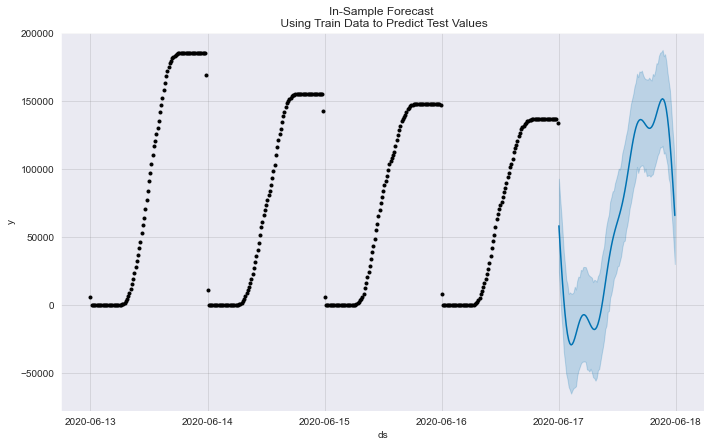

In [275]:
prophet_model.plot(prophet_test_forecast)
plt.title('In-Sample Forecast \n Using Train Data to Predict Test Values');

#### **PERFORMANCE METRICS; PLOTTING**

I'm going to create a dataframe of just my date_time index, predicted daily yield (yhat), and actual daily yield (y). I will then calculate the performance metrics of my prophet model and plot everything.

In [276]:
pred_metric_df = prophet_test_forecast.set_index('ds')[['yhat']].join(prophet_test.set_index('ds').y).reset_index()
pred_metric_df.set_index('ds', inplace=True)
pred_metric_df[pred_metric_df.yhat < 0] = 0
pred_metric_df

,yhat,y
ds,,
2020-06-17 00:00:00,58157.483263,6955.232143
2020-06-17 00:15:00,43277.986849,0.000000
2020-06-17 00:30:00,29013.367322,0.000000
2020-06-17 00:45:00,15761.627529,0.000000
2020-06-17 01:00:00,3869.588867,0.000000
...,...,...
2020-06-17 22:45:00,119489.561615,129571.000000
2020-06-17 23:00:00,107812.235301,129571.000000
2020-06-17 23:15:00,94737.783380,129571.000000


Prophet Test R2 Score: 0.941193
---------------
Prophet Test MAE Score: 7681.413889
---------------
Prophet Test RMSE Score: 13927.544700
---------------


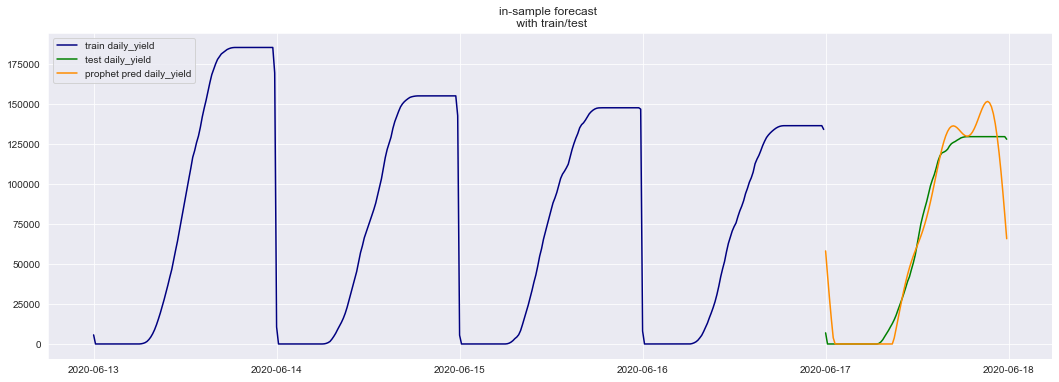

In [336]:
print('Prophet Test R2 Score: %f' % (r2_score(pred_metric_df.y, pred_metric_df.yhat)))
print('-'*15)

print('Prophet Test MAE Score: %f' % (mean_absolute_error(pred_metric_df.y, pred_metric_df.yhat)))
print('-'*15)

print('Prophet Test RMSE Score: %f' % (mean_squared_error(pred_metric_df.y, pred_metric_df.yhat,squared=False)))
print('-'*15)

plt.figure(figsize=(18,6))
plt.plot(prophet_train.ds, prophet_train.y, label='train daily_yield', c='navy')
plt.plot(prophet_test.ds, prophet_test.y, label='test daily_yield', c='green')
plt.plot(pred_metric_df.yhat, label = 'prophet pred daily_yield', color='darkorange')
plt.legend(loc='upper left')
plt.title('in-sample forecast \n with train/test');
# plt.savefig('../../data/figures/prophet_pred_model.png')

#### **FORECASTING 2 DAYS**

Just like before, I'm going to prepare the dataframe for the prophet model, with isolating and relabeling the date_time index and daily yield column as 'ds' and 'y'

In [282]:
prophet_pred_final = pred_final.copy()[['DAILY_YIELD']]
prophet_pred_final.reset_index(inplace=True)
prophet_pred_final.columns = ['ds', 'y']
prophet_pred_final

,ds,y
0,2020-06-13 00:00:00,5683.214286
1,2020-06-13 00:15:00,0.000000
2,2020-06-13 00:30:00,0.000000
3,2020-06-13 00:45:00,0.000000
4,2020-06-13 01:00:00,0.000000
...,...,...
475,2020-06-17 22:45:00,129571.000000
476,2020-06-17 23:00:00,129571.000000
477,2020-06-17 23:15:00,129571.000000
478,2020-06-17 23:30:00,129571.000000


I'm going to instantiate and fit the model to the data I prepared above.

In [283]:
prophet_model_forecast = Prophet(daily_seasonality=True,
                        weekly_seasonality=False,
                        yearly_seasonality=False,
                        interval_width=0.95)
prophet_model_forecast.fit(prophet_pred_final)

Just like above, I'm going to create a list of future dates to forecast solar power output against.

In [284]:
prophet_forecast_dates = prophet_model_forecast.make_future_dataframe(periods=192, include_history=False, freq='15min')
prophet_forecast_dates

,ds
0,2020-06-18 00:00:00
1,2020-06-18 00:15:00
2,2020-06-18 00:30:00
3,2020-06-18 00:45:00
4,2020-06-18 01:00:00
...,...
187,2020-06-19 22:45:00
188,2020-06-19 23:00:00
189,2020-06-19 23:15:00
190,2020-06-19 23:30:00


I'm going to use the model above to now forecast solar output. In addtion to that, I'm going to isolate the forecasted values (yhat) and the confidence intervals, so I can plot it.

In [305]:
prophet_forecast = prophet_model_forecast.predict(prophet_forecast_dates)
prophet_forecast = prophet_forecast[['ds','yhat_lower','yhat_upper','yhat']]
prophet_forecast.set_index('ds',inplace=True)
prophet_forecast[prophet_forecast < 0] = 0
prophet_forecast

,yhat_lower,yhat_upper,yhat
ds,,,
2020-06-18 00:00:00,19642.970926,88677.568945,54061.919557
2020-06-18 00:15:00,6827.558908,75397.866771,39673.304254
2020-06-18 00:30:00,0.000000,59511.630959,25887.823844
2020-06-18 00:45:00,0.000000,44500.807393,13087.847986
2020-06-18 01:00:00,0.000000,36761.040216,1605.952297
...,...,...,...
2020-06-19 22:45:00,70782.319896,141813.624298,108207.942241
2020-06-19 23:00:00,58242.616903,130782.028056,96861.441393
2020-06-19 23:15:00,47943.837339,120160.907106,84173.192763


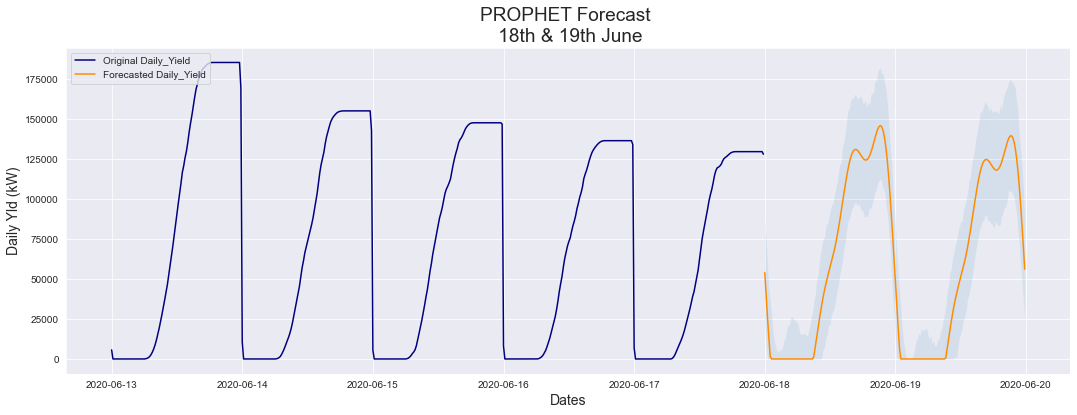

In [338]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(prophet_pred_final.ds, prophet_pred_final.y, label='Original Daily_Yield', c='navy')
ax.plot(prophet_forecast.index, prophet_forecast.yhat, label = 'Forecasted Daily_Yield', color='darkorange')
ax.fill_between(prophet_forecast.index, 
                prophet_forecast.yhat_lower, prophet_forecast.yhat_upper, alpha=0.1)
ax.legend(loc='upper left')
ax.set_title('PROPHET Forecast \n 18th & 19th June', size=19)
ax.set_ylabel('Daily Yld (kW)', size=14)
ax.set_xlabel('Dates', size=14);
# plt.savefig('../../data/figures/prophet_forecast.png')

In [335]:
print('18th Jun Forecasted Output: ', 
     round(prophet_forecast[prophet_forecast.index.day == 18]['yhat'].max(), 0),
     'kW')

print('19th Jun Forecasted Output: ', 
     round(prophet_forecast[prophet_forecast.index.day == 19]['yhat'].max(), 0),
     'kW')

18th Jun Forecasted Output:  145849.0 kW
19th Jun Forecasted Output:  139588.0 kW


---

# Modeling 3: SARIMAX

This is the same algorithm as SARIMA; the 'X' here stands for exogenous. These are variables, which in my case here is the ambient temperature, we can add in addition to the endogenous variable, or the main feature which in my case is the daily yield, to help the model predict and forecast better.

In [197]:
train_sarimax = train_pred_fin[['DAILY_YIELD']]
test_sarimax = test_pred_fin[['DAILY_YIELD']]

# Exogenous Variable (Ambient Temperature)
train_sarimax_exog = train_pred_fin[['AMBIENT_TEMPERATURE']]
test_sarimax_exog = test_pred_fin[['AMBIENT_TEMPERATURE']]

In [193]:
train_sarimax.head()

,DAILY_YIELD
DATE_TIME,
2020-06-13 00:00:00,5683.214286
2020-06-13 00:15:00,0.000000
2020-06-13 00:30:00,0.000000
2020-06-13 00:45:00,0.000000
2020-06-13 01:00:00,0.000000


In [194]:
train_sarimax_exog.head()

,AMBIENT_TEMPERATURE
DATE_TIME,
2020-06-13 00:00:00,21.771613
2020-06-13 00:15:00,21.730046
2020-06-13 00:30:00,21.687068
2020-06-13 00:45:00,21.619232
2020-06-13 01:00:00,21.625968


In [195]:
test_sarimax.head()

,DAILY_YIELD
DATE_TIME,
2020-06-17 00:00:00,6955.232143
2020-06-17 00:15:00,0.000000
2020-06-17 00:30:00,0.000000
2020-06-17 00:45:00,0.000000
2020-06-17 01:00:00,0.000000


In [198]:
test_sarimax_exog.head()

,AMBIENT_TEMPERATURE
DATE_TIME,
2020-06-17 00:00:00,22.895672
2020-06-17 00:15:00,22.868416
2020-06-17 00:30:00,22.826764
2020-06-17 00:45:00,22.795615
2020-06-17 01:00:00,22.771452


#### **AUTO-ARIMA**

--> **ENTER EXPLANATION AIC (since that is what we're minimizing here)** <--

In [189]:
auto_arima(train_sarimax,
           exogenous=train_sarimax_exog,
           start_p=0,d=1,start_q=0,
           max_p=4,max_d=4,max_q=4,
           start_P=0,D=1,start_Q=0,
           max_P=1,max_D=1,max_Q=1,m=96,
           seasonal=True,
           error_action='warn',trace=True,
           supress_warning=True,stepwise=True,
           random_state=20,n_fits=1)

Performing stepwise search to minimize aic


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'


 ARIMA(0,1,0)(0,1,0)[96]             : AIC=5087.452, Time=11.62 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'


 ARIMA(1,1,0)(1,1,0)[96]             : AIC=4787.500, Time=52.33 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,1)(0,1,1)[96]             : AIC=4866.556, Time=17.19 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'


 ARIMA(1,1,0)(0,1,0)[96]             : AIC=5071.438, Time=2.47 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,0)(1,1,1)[96]             : AIC=4764.205, Time=76.24 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,0)(0,1,1)[96]             : AIC=4865.263, Time=17.87 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,0)(1,1,1)[96]             : AIC=4910.129, Time=29.99 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(2,1,0)(1,1,1)[96]             : AIC=4766.203, Time=88.44 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,1)(1,1,1)[96]             : AIC=4869.406, Time=80.01 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(0,1,1)(1,1,1)[96]             : AIC=4764.404, Time=70.14 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/oz/opt/anaconda3/lib/python3

 ARIMA(2,1,1)(1,1,1)[96]             : AIC=4870.545, Time=46.58 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


 ARIMA(1,1,0)(1,1,1)[96] intercept   : AIC=4765.554, Time=93.48 sec

Best model:  ARIMA(1,1,0)(1,1,1)[96]          
Total fit time: 586.640 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 1, 1, 96),
      with_intercept=False)

#### **TRAIN/TEST MODEL, AND IN-SAMPLE PREDICTION**

FITTING MODEL TO TRAIN DATA

In [207]:
p,d,q = [1,1,0]
P,D,Q,s = [1,1,1,96]

sarimax_model = SARIMAX(endog=train_sarimax,
                        exog=train_sarimax_exog,
                        order=(p,d,q),
                        seasonal_order=(P,D,Q,s),
                        freq='15T').fit()

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'


MAKING PREDICTIONS AGAINST TRAIN AND TEST DATA (y_hats)

In [209]:
train_sarimax_y_hat = pd.DataFrame(sarimax_model.predict(typ='levels'), columns=['pred_daily_yld'])

test_sarimax_y_hat = pd.DataFrame(sarimax_model.predict(start=test_sarimax.index[0],
                                                        end=test_sarimax.index[-1],
                                                        exog=test_sarimax_exog,
                                                        typ='levels'), columns=['pred_daily_yld'])

# zero out negative predictions:
train_sarimax_y_hat[train_sarimax_y_hat < 0] = 0

test_sarimax_y_hat[test_sarimax_y_hat < 0] = 0

In [210]:
train_sarimax_y_hat.head()

,pred_daily_yld
2020-06-13 00:00:00,20449.352895
2020-06-13 00:15:00,5291.924688
2020-06-13 00:30:00,0.000000
2020-06-13 00:45:00,0.000000
2020-06-13 01:00:00,8.365063


In [211]:
test_sarimax_y_hat.head()

,pred_daily_yld
2020-06-17 00:00:00,0.0
2020-06-17 00:15:00,0.0
2020-06-17 00:30:00,0.0
2020-06-17 00:45:00,0.0
2020-06-17 01:00:00,0.0


PERFORMANCE METRICS; PLOTTING

SARIMAX train R2 Score: 0.986672
SARIMAX test R2 Score: 0.993385
---------------
SARIMAX train MAE Score: 1244.521925
SARIMAX test MAE Score: 3282.352611
---------------
SARIMAX train RMSE Score: 7899.641976
SARIMAX test RMSE Score: 4629.702527
--------------- 

                                      SARIMAX Results                                       
Dep. Variable:                          DAILY_YIELD   No. Observations:                  384
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 96)   Log Likelihood               -2377.102
Date:                              Wed, 02 Dec 2020   AIC                           4764.205
Time:                                      20:20:45   BIC                           4782.502
Sample:                                  06-13-2020   HQIC                          4771.538
                                       - 06-16-2020                                         
Covariance Type:                                opg                                   

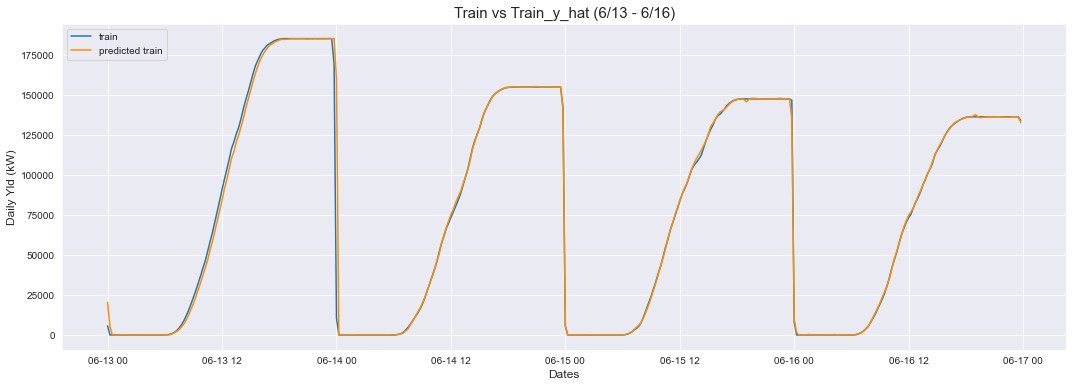

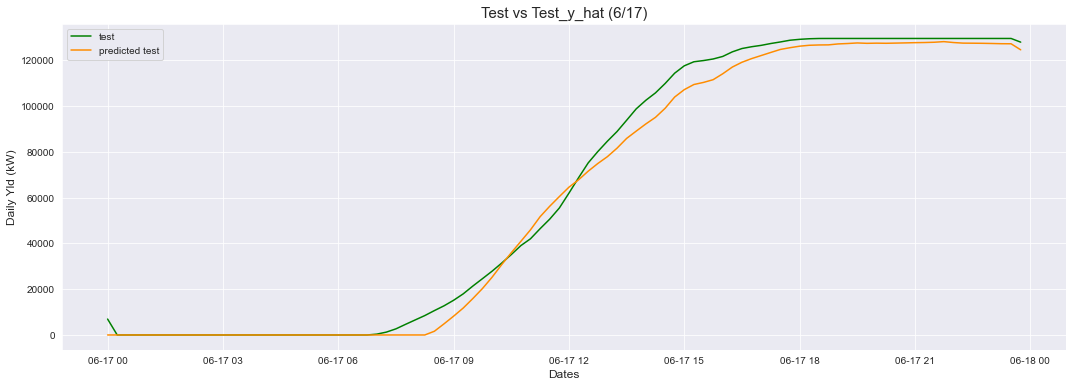

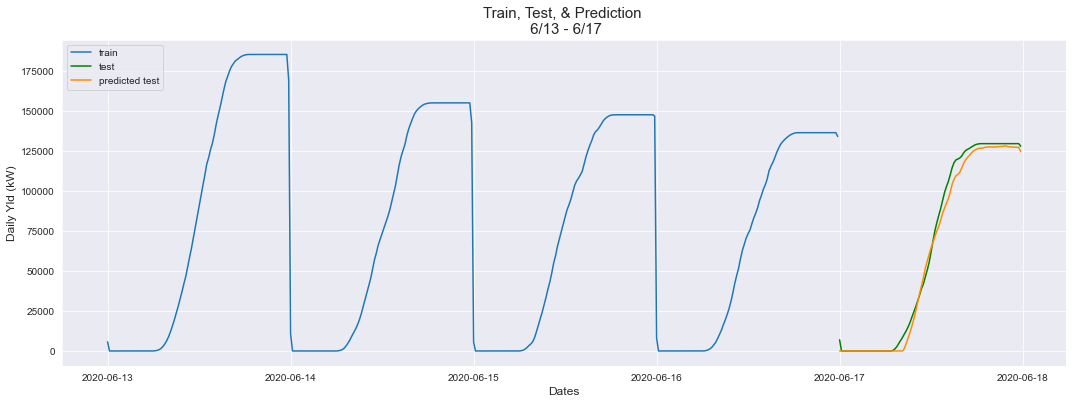

In [340]:
print('SARIMAX train R2 Score: %f' % (r2_score(train_sarimax.DAILY_YIELD,
                                              train_sarimax_y_hat.pred_daily_yld)))
print('SARIMAX test R2 Score: %f' % (r2_score(test_sarimax.DAILY_YIELD,
                                              test_sarimax_y_hat.pred_daily_yld)))

print('-'*15)

print('SARIMAX train MAE Score: %f' % (mean_absolute_error(train_sarimax.DAILY_YIELD,
                                                          train_sarimax_y_hat.pred_daily_yld)))
print('SARIMAX test MAE Score: %f' % (mean_absolute_error(test_sarimax.DAILY_YIELD,
                                                          test_sarimax_y_hat.pred_daily_yld)))

print('-'*15)

print('SARIMAX train RMSE Score: %f' % (mean_squared_error(train_sarimax.DAILY_YIELD,
                                                          train_sarimax_y_hat.pred_daily_yld,
                                                          squared=False)))
print('SARIMAX test RMSE Score: %f' % (mean_squared_error(test_sarimax.DAILY_YIELD,
                                                          test_sarimax_y_hat.pred_daily_yld,
                                                          squared=False)))

print('-'*15, '\n')

print(sarimax_model.summary())

print('-'*15)

fig, ax1 = plt.subplots(figsize=(18,6))
ax1.plot(train_sarimax, label='train')
ax1.plot(train_sarimax_y_hat, label='predicted train', c='darkorange')
ax1.legend(loc='upper left')
ax1.set_title('Train vs Train_y_hat (6/13 - 6/16)', size=15)
ax1.set_ylabel('Daily Yld (kW)', size=12)
ax1.set_xlabel('Dates', size=12) 

fig, ax2 = plt.subplots(figsize=(18,6))
ax2.plot(test_sarimax, label='test', c='g')
ax2.plot(test_sarimax_y_hat, label='predicted test', c='darkorange')
ax2.legend(loc='upper left')
ax2.set_title('Test vs Test_y_hat (6/17)', size=15)
ax2.set_ylabel('Daily Yld (kW)', size=12)
ax2.set_xlabel('Dates', size=12) 

fig, ax3 = plt.subplots(figsize=(18,6))
ax3.plot(train_sarimax, label='train')
ax3.plot(test_sarimax, label='test', c='g')
ax3.plot(test_sarimax_y_hat, label='predicted test', c='darkorange')
ax3.legend(loc='upper left')
ax3.set_title('Train, Test, & Prediction \n 6/13 - 6/17', size=15)
ax3.set_ylabel('Daily Yld (kW)', size=12)
ax3.set_xlabel('Dates', size=12);
# plt.savefig('../../data/figures/sarimax_pred.png')

#### **RETRIEVING HISTORICAL WEATHER DATA- FOR FORECASTING**

In [232]:
resp = requests.get('https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?aggregateHours=0&aggregateMinutes=15&combinationMethod=aggregate&startDateTime=2020-06-17T00%3A00%3A00&endDateTime=2020-06-22T00%3A00%3A00&maxStations=-1&maxDistance=-1&contentType=json&unitGroup=metric&locationMode=array&key=W9LFIRDB34JXS3E2KUHGX3RD9&dataElements=default&locations=Nashik%2C%20India')
forecast_wthr_data_all = pd.DataFrame.from_dict(resp.json()['locations'][0]['values'])
forecast_wthr_data_all.head()

,temp,maxt,visibility,wspd,datetimeStr,heatindex,cloudcover,mint,datetime,precip,weathertype,snowdepth,humidity,wgust,conditions,windchill
0,NaN,NaN,NaN,NaN,2020-06-17T00:00:00+05:30,NaN,NaN,NaN,1592352000000,0.0,None,None,NaN,None,,None
1,NaN,NaN,NaN,NaN,2020-06-17T00:15:00+05:30,NaN,NaN,NaN,1592352900000,0.0,None,None,NaN,None,,None
2,NaN,NaN,NaN,NaN,2020-06-17T00:30:00+05:30,NaN,NaN,NaN,1592353800000,0.0,None,None,NaN,None,,None
3,NaN,NaN,NaN,NaN,2020-06-17T00:45:00+05:30,NaN,NaN,NaN,1592354700000,0.0,None,None,NaN,None,,None
4,NaN,NaN,NaN,NaN,2020-06-17T01:00:00+05:30,NaN,NaN,NaN,1592355600000,0.0,None,None,NaN,None,,None


In [233]:
# removing '+05:30' from the string date time column

forecast_wthr_data_all.datetimeStr = forecast_wthr_data_all.datetimeStr.map(lambda x: x[:-6])


# changing date time column to datetime object, and then setting it as index

forecast_wthr_data_all.datetimeStr = pd.to_datetime(forecast_wthr_data_all.datetimeStr, infer_datetime_format=True)
forecast_wthr_data_all.set_index('datetimeStr', inplace=True)
forecast_wthr_data_all.head()

,temp,maxt,visibility,wspd,heatindex,cloudcover,mint,datetime,precip,weathertype,snowdepth,humidity,wgust,conditions,windchill
datetimeStr,,,,,,,,,,,,,,,
2020-06-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592352000000,0.0,None,None,NaN,None,,None
2020-06-17 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592352900000,0.0,None,None,NaN,None,,None
2020-06-17 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592353800000,0.0,None,None,NaN,None,,None
2020-06-17 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592354700000,0.0,None,None,NaN,None,,None
2020-06-17 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592355600000,0.0,None,None,NaN,None,,None


In [234]:
# Isolate temperature data

forecast_wthr_temp = forecast_wthr_data_all[['temp']]
forecast_wthr_temp.head()

,temp
datetimeStr,
2020-06-17 00:00:00,NaN
2020-06-17 00:15:00,NaN
2020-06-17 00:30:00,NaN
2020-06-17 00:45:00,NaN
2020-06-17 01:00:00,NaN


In [235]:
# checking for amount of nans

forecast_wthr_temp.isna().sum()

temp    229
dtype: int64

In [236]:
# interpolate

forecast_wthr_temp.interpolate(inplace=True)
forecast_wthr_temp

<ipython-input-236-8f891af3e272>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_wthr_temp.interpolate(inplace=True)


,temp
datetimeStr,
2020-06-17 00:00:00,NaN
2020-06-17 00:15:00,NaN
2020-06-17 00:30:00,NaN
2020-06-17 00:45:00,NaN
2020-06-17 01:00:00,NaN
...,...
2020-06-21 22:15:00,23.1
2020-06-21 22:30:00,23.1
2020-06-21 22:45:00,23.1


In [237]:
# Isolate historical temp data for forecasting period (6/18 and 6/19)

forecast_wthr_temp = forecast_wthr_temp[(forecast_wthr_temp.index >= '2020-06-18 00:00:00') & (forecast_wthr_temp.index <= '2020-06-20 00:00:00')]
forecast_wthr_temp

,temp
datetimeStr,
2020-06-18 00:00:00,24.609091
2020-06-18 00:15:00,24.563636
2020-06-18 00:30:00,24.518182
2020-06-18 00:45:00,24.472727
2020-06-18 01:00:00,24.427273
...,...
2020-06-19 23:00:00,25.645455
2020-06-19 23:15:00,25.600000
2020-06-19 23:30:00,25.600000


#### **FORECASTING**

Fit the model to the entire train/test data:

In [239]:
sarimax_f_model = SARIMAX(endog=pred_final.DAILY_YIELD,
                          exog=pred_final.AMBIENT_TEMPERATURE,
                          order=(p,d,q),
                          seasonal_order=(P,D,Q,s),
                          freq='15T').fit()

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Get Forecast- 2 days ahead

In [241]:
sarimax_forecast = sarimax_f_model.get_forecast(steps=193, exog=forecast_wthr_temp).summary_frame()
sarimax_forecast

DAILY_YIELD,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-06-18 00:00:00,2900.877472,1513.535719,-65.598027,5867.352970
2020-06-18 00:15:00,-4115.861118,2203.376783,-8434.400257,202.678020
2020-06-18 00:30:00,-4108.961410,2726.769316,-9453.331064,1235.408244
2020-06-18 00:45:00,-4117.784166,3164.904513,-10320.883025,2085.314694
2020-06-18 01:00:00,-4138.134078,3549.369693,-11094.770844,2818.502689
...,...,...,...,...
2020-06-19 23:00:00,124902.771096,32275.700700,61643.560149,188161.982043
2020-06-19 23:15:00,124957.950535,32407.805039,61439.819841,188476.081230
2020-06-19 23:30:00,124991.943048,32539.373050,61215.943790,188767.942305
2020-06-19 23:45:00,122929.699314,32670.410892,58896.870606,186962.528021


In [247]:
# zero out negative predictions

sarimax_forecast[sarimax_forecast < 0] = 0
sarimax_forecast

DAILY_YIELD,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-06-18 00:00:00,2900.877472,1513.535719,0.000000,5867.352970
2020-06-18 00:15:00,0.000000,2203.376783,0.000000,202.678020
2020-06-18 00:30:00,0.000000,2726.769316,0.000000,1235.408244
2020-06-18 00:45:00,0.000000,3164.904513,0.000000,2085.314694
2020-06-18 01:00:00,0.000000,3549.369693,0.000000,2818.502689
...,...,...,...,...
2020-06-19 23:00:00,124902.771096,32275.700700,61643.560149,188161.982043
2020-06-19 23:15:00,124957.950535,32407.805039,61439.819841,188476.081230
2020-06-19 23:30:00,124991.943048,32539.373050,61215.943790,188767.942305
2020-06-19 23:45:00,122929.699314,32670.410892,58896.870606,186962.528021


Plotting

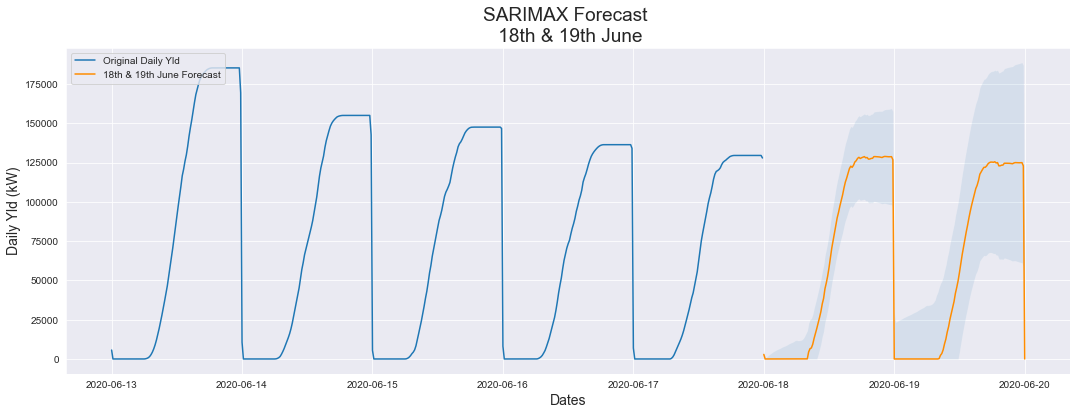

In [341]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pred_final.DAILY_YIELD, label='Original Daily Yld')
ax.plot(sarimax_forecast['mean'], label='18th & 19th June Forecast', c='darkorange')
ax.fill_between(sarimax_forecast.index, 
                sarimax_forecast.mean_ci_lower, sarimax_forecast.mean_ci_upper, alpha=0.1)

ax.legend(loc='upper left')
ax.set_title('SARIMAX Forecast \n 18th & 19th June', size=19)
ax.set_ylabel('Daily Yld (kW)', size=14)
ax.set_xlabel('Dates', size=14);
# plt.savefig('../../data/figures/sarimax_forecast.png')

In [249]:
print('18th Jun Forecasted Output: ', 
     round(sarimax_forecast[sarimax_forecast.index.day == 18]['mean'].max(), 0),
     'kW')

print('19th Jun Forecasted Output: ', 
     round(sarimax_forecast[sarimax_forecast.index.day == 19]['mean'].max(), 0),
     'kW')

18th Jun Forecasted Output:  128946.0 kW
19th Jun Forecasted Output:  125548.0 kW
